Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de> <br>
License: BSD Style.

In [1]:
import pandas as pd
import numpy as np

# time
import os
import sys
import time
from datetime import datetime
from datetime import date

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve


# Boosting classifiers
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Save model
import pickle
import joblib

In [2]:
gender_as_an_input = 'Yes'
chosen_feature_predicting = 'rating_count'
chosen_bin_method = 'quartiles'
chosen_success_class = 'movie_class'
chosen_dataset_ratio = 'unbalanced'
chosen_scaling_method = 'None'
default_learning_rate = 0.1
chosen_max_leaf_nodes = 32
default_max_depth = 3
chosen_max_features = None
chosen_random_state = 42
default_learning_rate = 0.1

In [3]:
df = pd.read_csv('visualize.csv', index_col=0)
df

,review_count_user,review_count_critic,metascore,rating_value,runtime,movie_year,opening_weekend_value,open_wk_cur_AUD,open_wk_cur_CAD,open_wk_cur_DEM,...,Winner_Actress,Winner_Actress in a Leading Role,Winner_Actress in a Supporting Role,Winner_Assistant Director,Winner_Directing,Winner_Directing (Comedy Picture),Winner_Directing (Dramatic Picture),movie_class,Gender_Female,Gender_Male
0,418,263,98,8.3,153.0,1927,1070.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,average,0,1
1,213,119,96,8.6,87.0,1936,11507.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,excellent,0,1
2,540,213,100,8.1,102.0,1939,5354311.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,excellent,0,1
3,540,213,100,8.1,102.0,1939,5354311.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,excellent,0,1
4,317,124,44,6.4,118.0,2001,2562448.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,average,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,75,159,99,8.7,111.0,2016,402075.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,terrible,0,1
3704,3,7,75,7.2,100.0,2015,12000.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,terrible,0,1
3705,11,77,87,7.8,142.0,2016,29129.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,terrible,0,1
3706,32,28,30,4.6,103.0,2016,28501448.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,terrible,0,1


In [4]:
def divide_test_train_with_scaling_methods(df,predict= chosen_success_class,scalingMethod = "MinMaxScaler"):
    
    labelClass = ['terrible','poor','average','excellent']
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
#     lb = preprocessing.LabelBinarizer()
#     y = lb.fit_transform(y)
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        new_X = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        new_X = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20, random_state = 42 , stratify = y )
    
    return X_train, X_test, y_train, y_test

In [5]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(df,scalingMethod= chosen_scaling_method)

No Scaling Method used or incorrect input


In [6]:
# Create classifiers
gb_clf = GradientBoostingClassifier(n_estimators=100,
                                     learning_rate= default_learning_rate,
                                     max_leaf_nodes= chosen_max_leaf_nodes,
                                     max_features= chosen_max_features,
                                     max_depth= default_max_depth,
                                     random_state= chosen_random_state
                                    )

xgb_clf = XGBClassifier(n_estimators=100,
                        learning_rate=default_learning_rate,
                        max_leaf_nodes= chosen_max_leaf_nodes,
                        max_features= chosen_max_features,
                        max_depth= default_max_depth,
                        random_state= chosen_random_state
                       )

ValueError: Only binary classification is supported. Provided labels ['average' 'excellent' 'poor' 'terrible'].

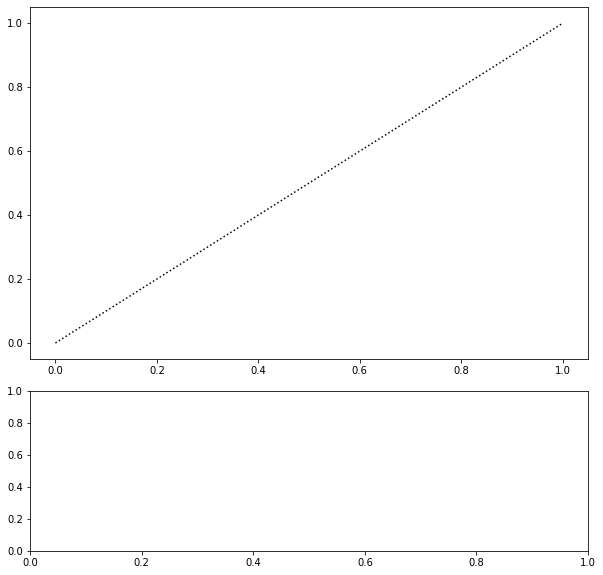

In [7]:
# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(gb_clf, 'Gradient Boost'),
                  (xgb_clf, 'Extreme Gradient Boost')
                 ]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [ ]:


import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()